In [112]:
import pandas as pd  
import matplotlib.pyplot as plt
import datetime, random
import numpy as np; np.random.seed(0)
import matplotlib.pyplot as plt
from sklearn import preprocessing
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense, Lambda
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers.merge import concatenate as concat
from keras import backend as K
from keras.optimizers import Adam
%matplotlib inline

In [113]:
stocks_df = pd.read_csv("5yr_data2.csv", parse_dates=['date'])

In [114]:
stocks_df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,67.7142,68.4014,66.8928,67.8542,158168416,AAPL
1,2013-02-11,68.0714,69.2771,67.6071,68.5614,129029425,AAPL
2,2013-02-12,68.5014,68.9114,66.8205,66.8428,151829363,AAPL
3,2013-02-13,66.7442,67.6628,66.1742,66.7156,118721995,AAPL
4,2013-02-14,66.3599,67.3771,66.2885,66.6556,88809154,AAPL


In [115]:
print('Stocks found:', len(set(stocks_df['Name'])))
print('Date range:', str(np.min(stocks_df['date']))[:10], '-', str(np.max(stocks_df['date']))[:10])

Stocks found: 29
Date range: 2013-02-08 - 2018-02-07


In [116]:
stocks_df['day'] = stocks_df['date'].dt.weekday
stocks_df['day_of_month'] = stocks_df['date'].dt.day
stocks_df.head()

,date,open,high,low,close,volume,Name,day,day_of_month
0,2013-02-08,67.7142,68.4014,66.8928,67.8542,158168416,AAPL,4,8
1,2013-02-11,68.0714,69.2771,67.6071,68.5614,129029425,AAPL,0,11
2,2013-02-12,68.5014,68.9114,66.8205,66.8428,151829363,AAPL,1,12
3,2013-02-13,66.7442,67.6628,66.1742,66.7156,118721995,AAPL,2,13
4,2013-02-14,66.3599,67.3771,66.2885,66.6556,88809154,AAPL,3,14


In [117]:
stock_symbols = list(set(stocks_df['Name']))

dow_30_list = ['AAL', 'AXP', 'BA', 'C', 'CAT', 'DD', 'DIS', 'GE', 'CSCO', 'HD', 'CVX', 'V', 'IBM',
'INTC', 'JNJ', 'JPM', 'KO', 'MCD', 'MMM', 'GS', 'MRK', 'MSFT', 'PFE', 'PG', 'AAPL', 'UTX', 'VZ',
'WMT', 'XOM', 'TRV']
 
dow_30_symbols = (list(set(dow_30_list) & set(stock_symbols)))

In [118]:
# apply some more quantitative features but make sure it doesn't spill from 
# one stock to another
market_data = {}
for symbol in dow_30_symbols:
    # segregate data for that stock so it doesn't spill into other one
    temp_df = stocks_df[stocks_df['Name'] == symbol]
    open = temp_df['open']
    high = temp_df['high']
    low = temp_df['low']
    close = temp_df['close']
    volume = temp_df['volume']
    close_avg_3 =  pd.DataFrame.rolling(temp_df['close'], 3).mean()
    print(close_avg_3)
    close_avg_5 =  pd.DataFrame.rolling(temp_df['close'], 5).mean()
    close_avg_10 =  pd.DataFrame.rolling(temp_df['close'], 10).mean()
    open_close = temp_df['close'] - temp_df['open']
    day_ = temp_df['day']
    day_of_month = temp_df['day_of_month']
    date = temp_df['date']
    # day of month
    

    
    market_data[symbol] = [open, high, low, close,
                                volume, close_avg_3, close_avg_5, close_avg_10, open_close, day_,
                               day_of_month, date]

32734          NaN
32735          NaN
32736    21.133333
32737    21.126667
32738    21.033333
32739    21.040000
32740    21.146667
32741    21.185000
32742    21.108333
32743    20.921667
32744    20.773333
32745    20.722667
32746    20.719333
32747    20.784333
32748    20.858333
32749    20.808333
32750    20.929333
32751    21.224333
32752    21.578333
32753    21.782333
32754    21.837333
32755    21.803333
32756    21.718333
32757    21.621667
32758    21.696667
32759    21.728333
32760    21.705000
32761    21.620000
32762    21.343333
32763    21.086667
           ...    
33963    38.520000
33964    38.530000
33965    38.543333
33966    38.483333
33967    38.583333
33968    38.776667
33969    39.006667
33970    39.230000
33971    39.486667
33972    39.720000
33973    39.846667
33974    39.900000
33975    40.293333
33976    40.503333
33977    40.870000
33978    41.013333
33979    41.263333
33980    41.416667
33981    41.683333
33982    41.976667
33983    42.056667
33984    42.

In [119]:
fin_open = []
fin_high = []
fin_low = []
fin_close = []
fin_volume = []
fin_close_avg_3 = []
fin_close_avg_5 = []
fin_close_avg_10 = []
fin_open_close = []

fin_day_ = []
fin_day_of_month = []
fin_date = []
fin_symbol = []

fin_high_high_diff3 = []
fin_low_low_diff3 = []
fin_open_open_diff3 = []
fin_close_close_diff3 = []
fin_volume_volume_diff3 = []


for key, value in market_data.items():
    fin_open.extend(list(value[0]))
    fin_high.extend(list(value[1]))
    fin_low.extend(list(value[2]))
    fin_close.extend(list(value[3]))
    fin_volume.extend(list(value[4]))
    
    fin_close_avg_3.extend(list(value[5]))
    
    fin_close_avg_5.extend(list(value[6]))
    fin_close_avg_10.extend(list(value[7]))
    fin_open_close.extend(list(value[8]))
    fin_day_.extend(list(value[9]))
    fin_day_of_month.extend(list(value[10]))
    fin_date.extend(list(value[11]))
    fin_symbol.extend([key] * len(value[11]))

# build final data frame for CVAE
norm_stocks_df = pd.DataFrame({'symbol':fin_symbol, 
                            'open':fin_open,
                            'high':fin_high,
                            'low':fin_low,
                            'close':fin_close,
                            'raw_close':fin_close,
                            'volume':fin_volume,
                            'raw_volume':fin_volume,
                            'close_avg_3':fin_close_avg_3,
                            'close_avg_5':fin_close_avg_5,
                            'close_avg_10':fin_close_avg_10,
                            'open_close':fin_open_close,
                            'raw_open_close':fin_open_close,
                            'day':fin_day_,
                            'day_of_month':fin_day_of_month,
                            'date':fin_date})

# remove any rows with NaN or inf columns
norm_stocks_df = norm_stocks_df.replace([np.inf, -np.inf], np.nan)
norm_stocks_df = norm_stocks_df.dropna(how='any')

norm_stocks_df

,symbol,open,high,low,close,raw_close,volume,raw_volume,close_avg_3,close_avg_5,close_avg_10,open_close,raw_open_close,day,day_of_month,date
9,CSCO,20.81,20.9300,20.7200,20.900,20.900,20483295,20483295,20.921667,21.0430,21.0745,0.090,0.090,4,22,2013-02-22
10,CSCO,21.00,21.1950,20.6500,20.660,20.660,37362549,37362549,20.773333,20.9770,21.0245,-0.340,-0.340,0,25,2013-02-25
11,CSCO,20.54,20.7800,20.5000,20.608,20.608,34254647,34254647,20.722667,20.8066,20.9583,0.068,0.068,1,26,2013-02-26
12,CSCO,20.60,21.0200,20.4400,20.890,20.890,25189601,25189601,20.719333,20.7636,20.9503,0.290,0.290,2,27,2013-02-27
13,CSCO,20.89,21.0450,20.7400,20.855,20.855,30335762,30335762,20.784333,20.7826,20.9218,-0.035,-0.035,3,28,2013-02-28
14,CSCO,20.71,20.9000,20.5500,20.830,20.830,24174763,24174763,20.858333,20.7686,20.9058,0.120,0.120,4,1,2013-03-01
15,CSCO,20.74,20.7800,20.5800,20.740,20.740,22632309,22632309,20.808333,20.7846,20.8808,0.000,0.000,0,4,2013-03-04
16,CSCO,20.83,21.2500,20.8300,21.218,21.218,32828986,32828986,20.929333,20.9066,20.8566,0.388,0.388,1,5,2013-03-05
17,CSCO,21.30,21.7900,21.2400,21.715,21.715,45966136,45966136,21.224333,21.0716,20.9176,0.415,0.415,2,6,2013-03-06
18,CSCO,21.72,21.9700,21.6800,21.802,21.802,37372123,37372123,21.578333,21.2610,21.0218,0.082,0.082,3,7,2013-03-07


In [120]:
features = [f for f in list(norm_stocks_df) if f not in ['date', 'symbol', 'raw_close', 'raw_open_close', 'raw_volume']]

df = norm_stocks_df.copy()

# Take all numerical cols and normalize data b/w 0 and 1
df[features] = df[features].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

print(features)

df['symbol'].value_counts()

['open', 'high', 'low', 'close', 'volume', 'close_avg_3', 'close_avg_5', 'close_avg_10', 'open_close', 'day', 'day_of_month']


TRV     1250
IBM     1250
BA      1250
XOM     1250
AAPL    1250
CVX     1250
INTC    1250
MRK     1250
CAT     1250
V       1250
JPM     1250
MMM     1250
MCD     1250
PG      1250
AXP     1250
DIS     1250
GS      1250
WMT     1250
UTX     1250
C       1250
GE      1250
CSCO    1250
JNJ     1250
PFE     1250
VZ      1250
MSFT    1250
KO      1250
HD      1250
Name: symbol, dtype: int64

In [121]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

label = df['symbol']

le= LabelEncoder().fit(label)
encoded_Y = le.transform(label)  # convert categorical labels to integers
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)

print(dummy_y[:4])

num_symbols = max(encoded_Y)
print(num_symbols)

[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]]
27


In [122]:
le.classes_

array(['AAPL', 'AXP', 'BA', 'C', 'CAT', 'CSCO', 'CVX', 'DIS', 'GE', 'GS',
       'HD', 'IBM', 'INTC', 'JNJ', 'JPM', 'KO', 'MCD', 'MMM', 'MRK',
       'MSFT', 'PFE', 'PG', 'TRV', 'UTX', 'V', 'VZ', 'WMT', 'XOM'],
      dtype=object)

In [111]:
len(le.classes_)

28

In [125]:
###################################################
## save the stock of interest for anomaly testing
stock_symbol_identifier = 0
print('Generate stock data for:', 
      le.classes_[stock_symbol_identifier])
###################################################

df_stock = df[df['symbol']==le.classes_[stock_symbol_identifier]].tail(100)
stock_dummy = dummy_y[1150:1250]
stock_dummy.fill(0)
stock_dummy[:,stock_symbol_identifier] = 1

 
## Break into train and test dataset
features = [f for f in list(norm_stocks_df)]
X_train, X_test, y_train, y_test = train_test_split(df[features], dummy_y, test_size=0.20, random_state=26)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.10, random_state=89)

# take copy of test set with symbol and date features for anomaly investigation
X_test_with_symbol = X_test.copy()
features = [f for f in list(norm_stocks_df) if f not in ['date', 'symbol',  'raw_close', 'raw_open_close', 'raw_volume']]
X_test = X_test[features]
X_train = X_train[features]
X_valid = X_valid[features]

print("X shape: ", X_train.shape, X_valid.shape, X_test.shape)
print("Y shape: ", y_train.shape, y_valid.shape, y_test.shape)


Generate stock data for: AAPL
X shape:  (25200, 11) (2800, 11) (7000, 11)
Y shape:  (25200, 28) (2800, 28) (7000, 28)


In [127]:
features

['open',
 'high',
 'low',
 'close',
 'volume',
 'close_avg_3',
 'close_avg_5',
 'close_avg_10',
 'open_close',
 'day',
 'day_of_month']

In [129]:
X_train.tail()


,open,high,low,close,volume,close_avg_3,close_avg_5,close_avg_10,open_close,day,day_of_month
25929,0.171430,0.171737,0.173539,0.173874,0.019934,0.170252,0.170853,0.170846,0.406052,0.00,0.000000
23227,0.213058,0.213025,0.216731,0.216589,0.017939,0.216153,0.219907,0.220261,0.412392,1.00,0.233333
14867,0.497570,0.500043,0.508671,0.504342,0.002947,0.507701,0.511458,0.510135,0.414409,1.00,0.766667
6533,0.171170,0.172026,0.173687,0.173347,0.011721,0.174381,0.176950,0.179119,0.403458,0.25,0.666667
17760,0.416455,0.415735,0.420360,0.415753,0.004448,0.423605,0.433073,0.442172,0.349280,0.50,0.666667


In [130]:
## discard incomplete batches
m = 50 # batch size

num_batches_train = X_train.shape[0]//m
print(num_batches_train)
X_train_trun = X_train.head(num_batches_train*m)
y_train_trun = y_train[:num_batches_train*m,:]
print(X_train_trun.shape, y_train_trun.shape)

num_batches_valid = X_valid.shape[0]//m
X_valid_trun = X_valid.head(num_batches_valid*m)
y_valid_trun = y_valid[:num_batches_valid*m,:]
print(X_valid_trun.shape, y_valid_trun.shape)

num_batches_test = X_test.shape[0]//m
X_test_trun = X_test.head(num_batches_test*m)
y_test_trun = y_test[:num_batches_test*m,:]
print(X_test_trun.shape, y_test_trun.shape)

504
(25200, 11) (25200, 28)
(2800, 11) (2800, 28)
(7000, 11) (7000, 28)


##PART2

In [131]:
## Define Hyperparmeters

m = 50 # batch size
n_z = 2 # latent space size
encoder_dim = 5 # dim of encoder hidden layer
decoder_dim = 5 # dim of decoder hidden layer
decoder_out_dim = X_train.shape[1] # dim of decoder output layer
activ = 'relu'
optim = Adam(lr=0.001)


n_x = X_train.shape[1]
n_y = y_train.shape[1]

In [132]:
## Explicitely define shape for the encoder
X = Input(shape=(n_x,))
label = Input(shape=(n_y,))

## Concatenate the input and the label for the CVAE
inputs = concat([X, label])

W0730 02:54:04.318141 11448 deprecation_wrapper.py:119] From F:\Programs\Anaconda\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0730 02:54:04.320137 11448 deprecation_wrapper.py:119] From F:\Programs\Anaconda\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.



In [133]:
encoder_h = Dense(encoder_dim, activation=activ)(inputs)
mu = Dense(n_z, activation='linear')(encoder_h)
l_sigma = Dense(n_z, activation='linear')(encoder_h)
## Define the latent space - z layer
def sample_z(args):
    mu, l_sigma = args
    eps = K.random_normal(shape=(m, n_z), mean=0., stddev=1.)
    return mu + K.exp(l_sigma / 2) * eps

W0730 02:54:37.775440 11448 deprecation_wrapper.py:119] From F:\Programs\Anaconda\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



In [134]:
# Sampling latent space
z = Lambda(sample_z, output_shape = (n_z, ))([mu, l_sigma])
# merge latent space with label
zc = concat([z, label])

W0730 02:54:52.475986 11448 deprecation_wrapper.py:119] From F:\Programs\Anaconda\lib\site-packages\keras\backend\tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.



In [135]:
decoder_hidden = Dense(decoder_dim, activation=activ)
decoder_out = Dense(decoder_out_dim, activation='sigmoid')
h_p = decoder_hidden(zc)
outputs = decoder_out(h_p)

In [137]:
## Model will be trained on vae loss

def vae_loss(y_true, y_pred):
    recon = K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)
    kl = 0.5 * K.sum(K.exp(l_sigma) + K.square(mu) - 1. - l_sigma, axis=-1)
    return recon + kl

def KL_loss(y_true, y_pred):
    return(0.5 * K.sum(K.exp(l_sigma) + K.square(mu) - 1. - l_sigma, axis=1))

def recon_loss(y_true, y_pred):
    return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)

# instantiate a the keras model class API
cvae = Model([X, label], outputs)
encoder = Model([X, label], mu)

d_in = Input(shape=(n_z+n_y,))
d_h = decoder_hidden(d_in)
d_out = decoder_out(d_h)
decoder = Model(d_in, d_out)

In [139]:
## Compile function
cvae.compile(optimizer=optim, loss=vae_loss, metrics = [KL_loss, recon_loss])

# compile and fit
n_epoch = 70
cvae_hist = cvae.fit([X_train_trun, y_train_trun], X_train_trun, verbose = 1, batch_size=m, epochs=n_epoch,
        validation_data = ([X_valid_trun, y_valid_trun], X_valid_trun),
        callbacks = [EarlyStopping(patience = 5)]).history

Train on 25200 samples, validate on 2800 samples
Epoch 1/70
25200/25200 [==============================] - 1s 57us/step - loss: 5.4587 - KL_loss: 1.7995e-06 - recon_loss: 5.4587 - val_loss: 5.4677 - val_KL_loss: 3.2141e-08 - val_recon_loss: 5.4677
Epoch 2/70
25200/25200 [==============================] - 1s 39us/step - loss: 5.4582 - KL_loss: 5.4540e-07 - recon_loss: 5.4582 - val_loss: 5.4674 - val_KL_loss: 5.2724e-07 - val_recon_loss: 5.4674
Epoch 3/70
25200/25200 [==============================] - 1s 41us/step - loss: 5.4579 - KL_loss: 3.8066e-07 - recon_loss: 5.4579 - val_loss: 5.4675 - val_KL_loss: 2.9391e-07 - val_recon_loss: 5.4675
Epoch 4/70
25200/25200 [==============================] - 1s 32us/step - loss: 5.4580 - KL_loss: 1.8418e-07 - recon_loss: 5.4580 - val_loss: 5.4668 - val_KL_loss: 1.5775e-07 - val_recon_loss: 5.4668
Epoch 5/70
25200/25200 [==============================] - 1s 32us/step - loss: 5.4579 - KL_loss: 3.5946e-07 - recon_loss: 5.4579 - val_loss: 5.4672 - val_K

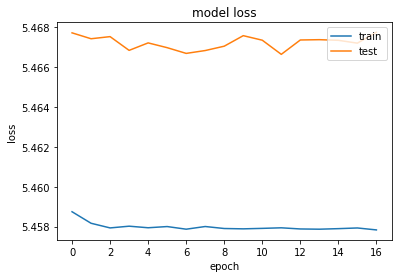

In [140]:
# ## Plot loss
# # Check plots - Loss
plt.plot(cvae_hist['loss'])
plt.plot(cvae_hist['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

##part 3

In [141]:
def construct_numvec(identifier, z = None):
    out = np.zeros((1, n_z + n_y))
    out[:, identifier + n_z] = 1.
    if z is None:
        return(out)
    else:
        for i in range(len(z)):
            out[:,i] = z[i]
        return(out)

In [142]:
## Since the training set is huge, we extract a random subset for calculating anamoly threhsold
X_exp, X_rem, y_exp, y_rem = train_test_split(X_train_trun, y_train_trun, test_size=0.20, random_state=19)

In [143]:

## Predict z-space for the subset of training data
z_dataset = encoder.predict([X_rem, y_rem])

In [144]:
print(z_dataset.shape)


(5040, 2)


In [145]:
# Append z1, z2 columns of the X_rem dataframe
X_rem['z1'] = z_dataset[:,0]
X_rem['z2'] = z_dataset[:,1]
X_rem.head()
# actual range of the 2 dimensions of z
print(np.max(X_rem['z1']))
print(np.min(X_rem['z1']))
print(np.max(X_rem['z2']))
print(np.min(X_rem['z2']))

0.00051357853
0.00051357853
-0.0010747805
-0.0010747805


In [146]:
### Define reconstruction error for training set as 
###the mean squared difference between actual column value and predicted column value

def recon_error_cal(actual,predictions):
    recon_error = np.mean(np.power(actual - predictions, 2))
    recon_array = np.power(actual - predictions, 2)
    max_col = np.argmax(recon_array)
    return recon_error, max_col

In [147]:
# Calculate reconstruction error for every row in X_rem (subset of training set)
recon_on_train = [] 
max_contributor =[]
for i in range(X_rem.shape[0]): # for each row:
    z1 = X_rem.iloc[i]['z1']
    z2 = X_rem.iloc[i]['z2']
    z_ = [z1,z2]  # Define z vector
    identifier = int(np.argmax(y_rem[i]))
    vec = construct_numvec(identifier, z_) # concatenate z and label before passing to the decoder
    # uses identifier and z value 
    test_pred = decoder.predict(vec)
    transpose = test_pred.T
    transpose = np.squeeze(transpose) ## decoder predictions
    actuals = X_rem.iloc[i][features]

    recon_error, max_col = recon_error_cal(actuals, transpose)  ## reconstuction error b/w actuals and predicted
    ## Add this error to recon list
    recon_on_train.append(recon_error)
    max_contributor.append(max_col[0])

In [148]:
len(max_contributor)


5040

In [149]:
test_pred


array([[0.28922564, 0.29097557, 0.2944993 , 0.29224545, 0.00870135,
        0.29484177, 0.29984677, 0.30232364, 0.39892122, 0.5024507 ,
        0.48341623]], dtype=float32)

In [150]:
recon_train_se = pd.Series(recon_on_train)
print("90th percentile recon error", np.percentile(recon_train_se, 90))
print("95th percentile recon error", np.percentile(recon_train_se, 95))
anomaly_threshold =  np.percentile(recon_train_se, 95)
print('Selected anomaly threshold: ', anomaly_threshold)

90th percentile recon error 0.038121328236287735
95th percentile recon error 0.04282600527774384
Selected anomaly threshold:  0.04282600527774384


##part 4

In [151]:

## Use encoder to predict the z-space for the test dataset
z_test = encoder.predict([X_test, y_test]) 
print(z_test.shape)

(7000, 2)


In [152]:
## Loop through every row of test dataset and calculate reconstruction error 

recon_on_test = []
max_contributor_test =[]

for i in range(z_test.shape[0]): # for each row:
    z_ = z_test[i]  # Define z vector
    identifier = int(np.argmax(y_test[i]))

    vec = construct_numvec(identifier, z_) # concatenate z and label before passing to the decoder
    test_pred = decoder.predict(vec)
    transpose = test_pred.T
    transpose = np.squeeze(transpose) #Decode predictions
    actuals = X_test.iloc[i]

    recon_error , max_col = recon_error_cal(actuals, transpose) # Error calculations 
    ## Add this error to recon list
    recon_on_test.append(recon_error)
    max_contributor_test.append(max_col)
    

recon_test_se = pd.Series(recon_on_test)
recon_test_se.shape

max_col_test = pd.Series(max_contributor_test)
max_col_test.shape

(7000,)

In [153]:
## Calculate Anomaly percent of the test dataset
anomaly_count = 0
for i in range(len(recon_test_se)):
    if recon_test_se[i] > anomaly_threshold:
        anomaly_count +=1
print(anomaly_count/X_test.shape[0])

0.056


In [155]:
# investigate what is being flagged as anomalous 
X_test_with_symbol['recon_error'] = recon_on_test

In [156]:

# get all rows with recon_error larger than anomaly_threshold
errs = X_test_with_symbol[X_test_with_symbol['recon_error'] > anomaly_threshold]
errs.sort_values('recon_error', ascending=False)

,symbol,open,high,low,close,raw_close,volume,raw_volume,close_avg_3,close_avg_5,close_avg_10,open_close,raw_open_close,day,day_of_month,date,recon_error
17622,BA,0.981196,0.981939,0.990099,0.976523,348.91,0.008384,5486074,1.000000,1.000000,0.997069,0.250720,-5.09,1.00,0.033333,2018-02-02,0.273188
17625,BA,0.942201,0.977290,0.963923,0.974213,348.12,0.012366,7946670,0.958307,0.990979,1.000000,0.616427,7.60,0.50,0.200000,2018-02-07,0.229411
17612,BA,0.945528,0.949583,0.951709,0.943835,337.73,0.011262,7264401,0.969136,0.976842,0.952234,0.283862,-3.94,1.00,0.600000,2018-01-19,0.229225
17613,BA,0.927071,0.942016,0.940711,0.944625,338.00,0.010499,6792870,0.956316,0.977920,0.961110,0.475504,2.71,0.00,0.700000,2018-01-22,0.229061
17591,BA,0.810750,0.814192,0.829484,0.822238,296.14,0.004202,2901644,0.826309,0.835700,0.825760,0.427954,1.06,0.00,0.566667,2017-12-18,0.144811
17598,BA,0.812862,0.813759,0.830137,0.822852,296.35,0.001831,1436751,0.829630,0.842754,0.851936,0.412968,0.54,0.75,0.900000,2017-12-28,0.144383
17596,BA,0.812081,0.815059,0.829870,0.819957,295.36,0.001763,1394737,0.827817,0.844667,0.848834,0.392219,-0.18,0.25,0.833333,2017-12-26,0.140166
17592,BA,0.814424,0.815463,0.828479,0.825483,297.25,0.003921,2728367,0.829630,0.840100,0.832369,0.423343,0.90,0.25,0.600000,2017-12-19,0.129608
17586,BA,0.785090,0.783421,0.786144,0.784288,283.16,0.006085,4065242,0.793859,0.799050,0.794621,0.309510,-3.05,0.00,0.333333,2017-12-11,0.129077
17593,BA,0.821743,0.820519,0.837162,0.827384,297.90,0.003606,2533689,0.833532,0.843747,0.838344,0.369164,-0.98,0.50,0.633333,2017-12-20,0.127241


In [157]:
##part 5

In [158]:
X_test.head()


,open,high,low,close,volume,close_avg_3,close_avg_5,close_avg_10,open_close,day,day_of_month
2764,0.027858,0.026899,0.028726,0.028155,0.046207,0.028114,0.027978,0.028148,0.400000,1.00,1.000000
25479,0.109248,0.108477,0.110508,0.108404,0.021158,0.108308,0.106917,0.107345,0.380187,0.75,0.533333
8132,0.174294,0.172835,0.177690,0.175219,0.007639,0.176884,0.180428,0.185472,0.390778,0.75,0.900000
10521,0.236982,0.236803,0.242255,0.238722,0.010237,0.239961,0.242854,0.242960,0.392219,0.50,0.600000
30206,0.188122,0.187946,0.191207,0.188668,0.025688,0.189212,0.190918,0.189000,0.385591,0.75,0.800000


In [159]:
df_stock[features].head()


,open,high,low,close,volume,close_avg_3,close_avg_5,close_avg_10,open_close,day,day_of_month
25080,0.415558,0.420762,0.424777,0.423852,0.078988,0.426078,0.435155,0.441466,0.438040,1.00,0.466667
25081,0.420302,0.419404,0.424762,0.420314,0.045254,0.425113,0.433452,0.439828,0.355908,0.00,0.566667
25082,0.418566,0.417295,0.426081,0.420489,0.033184,0.425556,0.432170,0.438809,0.374928,0.25,0.600000
25083,0.413909,0.412932,0.412415,0.412712,0.085197,0.421802,0.430016,0.437031,0.344669,0.50,0.633333
25084,0.407834,0.405825,0.409214,0.404877,0.060211,0.416599,0.427073,0.434635,0.327954,0.75,0.666667


In [160]:
## Use encoder to predict the z-space for the test dataset
features = [f for f in list(df_stock) if f not in ['date', 'symbol', 'raw_close', 'raw_volume', 'raw_open_close', 'recon_error']]
z_stock = encoder.predict([df_stock[features], stock_dummy]) 
print(z_stock.shape)

## Loop through each row of our single-stock dataset and calculate the reconstruction error 
recon_on_generated_stock = []
max_contributor_stock =[]

for i in range(z_stock.shape[0]):  
    z_ = z_stock[i]   
    identifier = int(np.argmax(stock_dummy[i]))

    vec = construct_numvec(identifier, z_) 
    test_pred = decoder.predict(vec)
    transpose = test_pred.T
    transpose = np.squeeze(transpose) 
    actuals = df_stock[features].iloc[i]

    recon_error , max_col = recon_error_cal(actuals, transpose) 
    ## Add this error to recon list
    recon_on_generated_stock.append(recon_error)
    max_contributor_stock.append(max_col)
    

recon_se = pd.Series(recon_on_generated_stock)
recon_se.shape

anomaly_threshold =  np.percentile(recon_se, 90)
print('anomaly_threshold:', anomaly_threshold)

max_col_test = pd.Series(max_contributor_stock)
max_col_test.shape


(100, 2)
anomaly_threshold: 0.06037744607444327


(100,)

In [161]:
df_stock['recon_error'] = recon_on_generated_stock

df_stock[(df_stock['date'] > '2018-01-01') & (df_stock['recon_error']> anomaly_threshold)].sort_values('recon_error', ascending=False)

,symbol,open,high,low,close,raw_close,volume,raw_volume,close_avg_3,close_avg_5,close_avg_10,open_close,raw_open_close,day,day_of_month,date,recon_error
25172,AAPL,0.449375,0.447314,0.451665,0.447475,167.96,0.081457,50640406,0.458371,0.472269,0.485223,0.334006,-2.20,0.0,0.933333,2018-01-29,0.068005
25176,AAPL,0.437341,0.437607,0.431002,0.425664,160.50,0.139641,86593825,0.443717,0.453492,0.469903,0.238905,-5.50,1.0,0.033333,2018-02-02,0.066378
25157,AAPL,0.458864,0.462367,0.469392,0.468058,175.00,0.037795,23660018,0.467910,0.472215,0.476752,0.442363,1.56,1.0,0.133333,2018-01-05,0.063138
25171,AAPL,0.454698,0.452631,0.460528,0.457855,171.51,0.062851,39143011,0.464539,0.477709,0.488002,0.383285,-0.49,1.0,0.833333,2018-01-26,0.061270


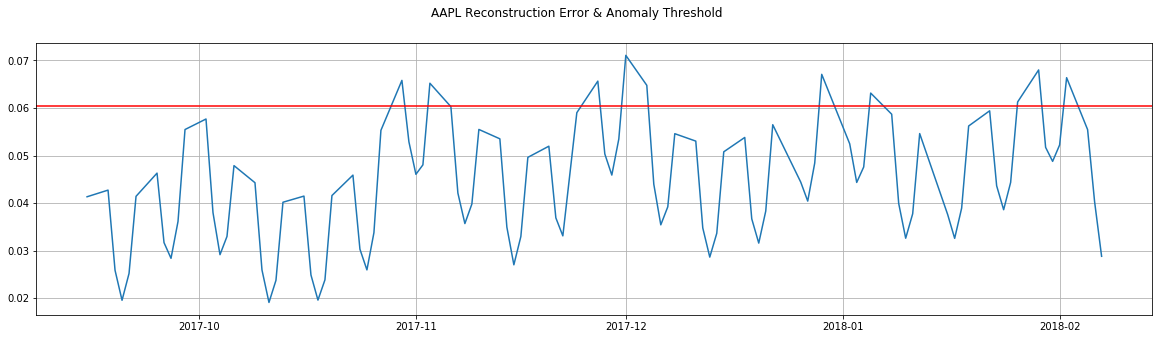

In [162]:
# investigate what is being flagged as anomalous 
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(111)
ax.plot(df_stock['date'], df_stock['recon_error'])
plt.suptitle(le.classes_[stock_symbol_identifier] + " Reconstruction Error & Anomaly Threshold")
plt.axhline(y=anomaly_threshold, color='r', linestyle='-')
ax.grid(True)

,symbol,open,high,low,close,raw_close,volume,raw_volume,close_avg_3,close_avg_5,close_avg_10,open_close,raw_open_close,day,day_of_month,date,recon_error
25175,AAPL,0.440711,0.442865,0.450746,0.446949,167.78,0.075939,47230787,0.450093,0.460118,0.475370,0.415130,0.615,0.75,0.000000,2018-02-01,0.052225
25176,AAPL,0.437341,0.437607,0.431002,0.425664,160.50,0.139641,86593825,0.443717,0.453492,0.469903,0.238905,-5.500,1.00,0.033333,2018-02-02,0.066378
25177,AAPL,0.417380,0.429170,0.418848,0.413940,156.49,0.117219,72738522,0.432937,0.446590,0.463660,0.322190,-2.610,0.00,0.133333,2018-02-05,0.055458
25178,AAPL,0.405028,0.428708,0.412919,0.433061,163.03,0.109945,68243838,0.428256,0.444218,0.459395,0.633718,8.200,0.25,0.166667,2018-02-06,0.040282
25179,AAPL,0.428908,0.427783,0.427944,0.422858,159.54,0.083024,51608580,0.427310,0.439470,0.454927,0.295245,-3.545,0.50,0.200000,2018-02-07,0.028811


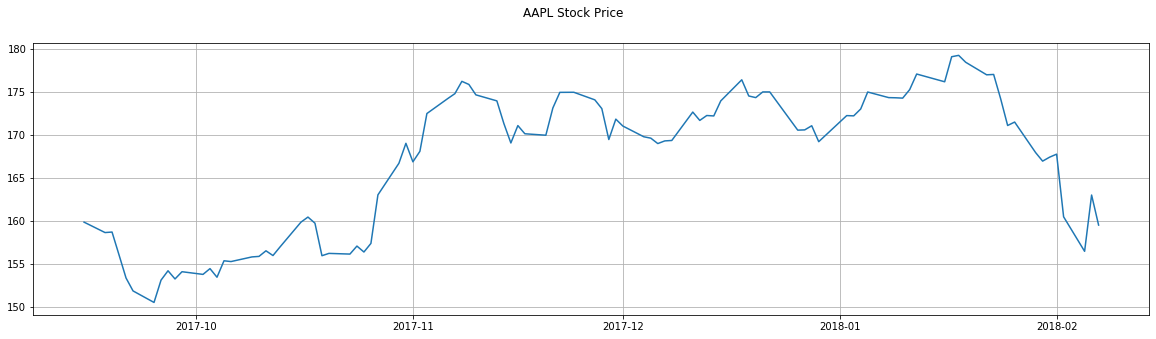

In [163]:
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(111)
ax.plot(df_stock['date'], df_stock['raw_close'])
ax.grid(True)
plt.suptitle(le.classes_[stock_symbol_identifier] + " Stock Price")
df_stock.tail()

[Timestamp('2017-12-29 00:00:00'), Timestamp('2018-01-05 00:00:00'), Timestamp('2018-01-26 00:00:00'), Timestamp('2018-01-29 00:00:00'), Timestamp('2018-02-02 00:00:00')]


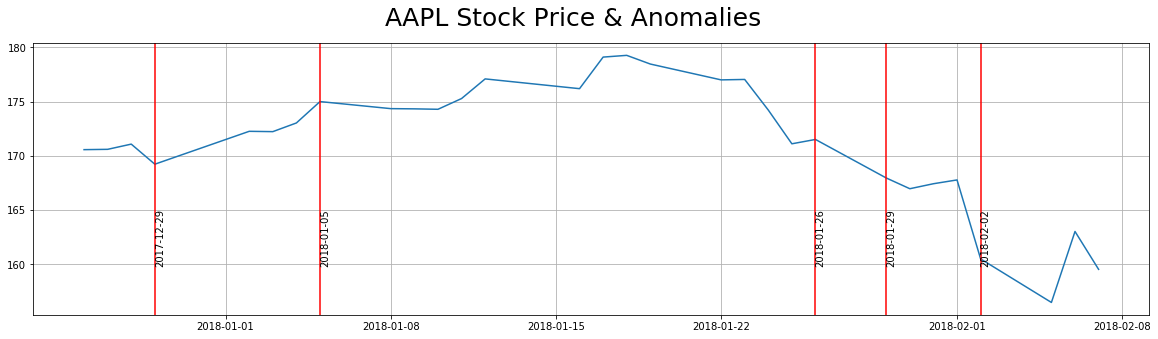

[Timestamp('2017-12-29 00:00:00'), Timestamp('2018-01-05 00:00:00'), Timestamp('2018-01-26 00:00:00'), Timestamp('2018-01-29 00:00:00'), Timestamp('2018-02-02 00:00:00')]


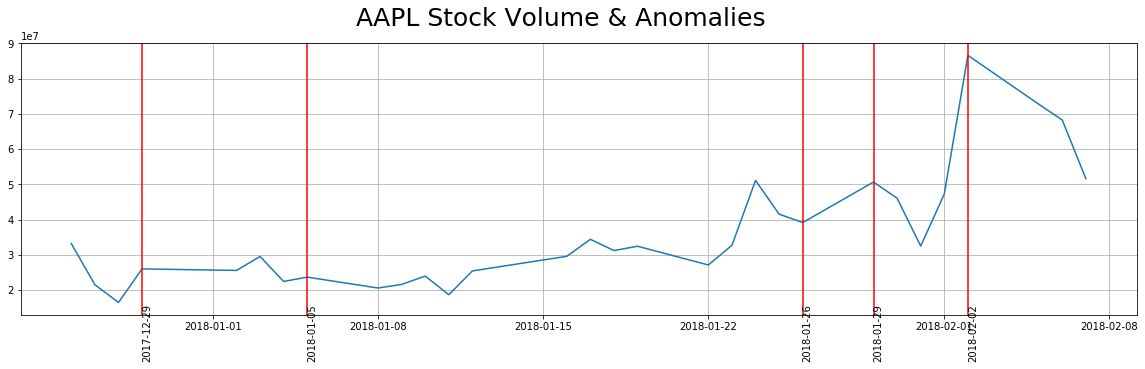

[Timestamp('2017-12-29 00:00:00'), Timestamp('2018-01-05 00:00:00'), Timestamp('2018-01-26 00:00:00'), Timestamp('2018-01-29 00:00:00'), Timestamp('2018-02-02 00:00:00')]


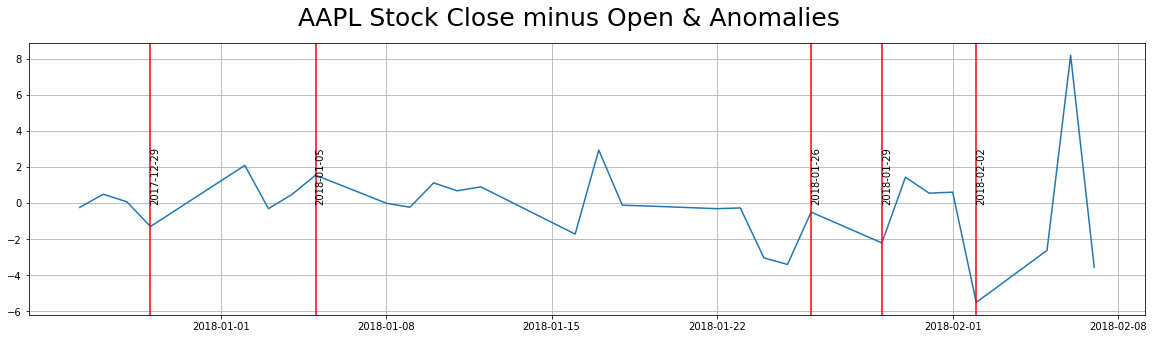

In [164]:
# print time series and highligh anomalies
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(111)
df_stock_tmp = df_stock.tail(30)
ax.plot(df_stock_tmp['date'], df_stock_tmp['raw_close'])
ax.grid(True)
plt.suptitle(le.classes_[stock_symbol_identifier] + " Stock Price & Anomalies", fontsize=25)

xcoords = [d for e,d in zip(df_stock_tmp['recon_error'], df_stock_tmp['date']) if e > anomaly_threshold]
for xc in xcoords:
    plt.axvline(x=xc, color='red')
    plt.text(xc, 160, str(xc)[:10], rotation=90)
print(xcoords)
plt.show()


# print time series and highligh anomalies
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(111)
df_stock_tmp = df_stock.tail(30)
ax.plot(df_stock_tmp['date'], df_stock_tmp['raw_volume'])
ax.grid(True)
plt.suptitle(le.classes_[stock_symbol_identifier] + " Stock Volume & Anomalies", fontsize=25)

xcoords = [d for e,d in zip(df_stock_tmp['recon_error'], df_stock_tmp['date']) if e > anomaly_threshold]
for xc in xcoords:
    plt.axvline(x=xc, color='red')
    plt.text(xc, 200000, str(xc)[:10], rotation=90)
print(xcoords)
plt.show()


# print time series and highligh anomalies
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(111)
df_stock_tmp = df_stock.tail(30)
ax.plot(df_stock_tmp['date'], df_stock_tmp['raw_open_close'])
ax.grid(True)
plt.suptitle(le.classes_[stock_symbol_identifier] + " Stock Close minus Open & Anomalies", fontsize=25)

xcoords = [d for e,d in zip(df_stock_tmp['recon_error'], df_stock_tmp['date']) if e > anomaly_threshold]
for xc in xcoords:
    plt.axvline(x=xc, color='red')
    plt.text(xc, 0, str(xc)[:10], rotation=90)
print(xcoords)
plt.show()